<a href="https://colab.research.google.com/github/takao-takenouchi/dp_tutorial/blob/main/DP_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part2: 応用（複数Contributionの対応）

# はじめに

Part2は、Part1に続いての応用編です。特に、Part1のはじめにで記載したGoogleが提供しているExampleを参考にして作成しています。

## 「Part2:応用（複数Contributionの対応）」の学習内容

Part2では以下の内容について学びます。
*   複数contributionへの対応方法、contributionの上限を設定
*   集計に応じたsensitibityの設計、事前集計によりsensitivityを減らす方法

# Contributionとは

Part1では、一人が1レコードでありました。しかし、実際のDBは１名が複数レコードに存在するケースはよくあります。このような、あるテーブルにある１名がどのくらいのレコードに存在するかをContributionという用語で表現しています。（表現例： 山田太郎のContributionは2である。テーブル全体でContributionは高々5である）

1名のユーザのプライバシーを保護するためには、その人がいる/いないに応じてsensitibityを考える必要があるため、contributionをどう考えるかは重要です。
もし、contribuionが無限大であるとすると、sensitibityが設定できず、DPを適用できません。そこで、Contributionに上限を設けるのが一つのやり方です。

例えば、ある1名があるECサイトで買い物するのは1日で高々4回程度とするのは、ある程度リーズナブルでしょう。
そして、それ以上の回数買い物するのは外れ値として削除して集計しても良いと思います。そうすれば、sensitivityを設定でき、DPを適用できるようになります。

なお、PyDPでは、`l0_sensitivity`の値で、このContributionの最大値を設定可能です。

# 分析シナリオ

今回は、ECサイトの収益データを集計する例を想定します。

このデータは、{来客者 VisitorID、入店時間、滞在時間、曜日}で構成されます。

集計者は、ECサイトの売上分析をしたい人（外部コンサル、外部の投資家など）とします。
コンサルであれば、このECサイトの売上をあげるために分析がしたく、投資家であればこのECサイトのポテンシャルを図りたいと思うでしょう。

集計のシナリオは以下の通りです。
* 集計者は、毎月や毎週の売上の推移を見たところ、売上が順調に伸びていないことに気づきました。そこで、**ある週に限定**して、細かく分析することにしました。（一般に分析とは、分割することや、比較することです。分割の方法としては、時間の観点や、計算式の観点が考えられます）
* ある週の売上は、時間の観点では、曜日に分割できます。また、売上高の観点では「売上 ＝ 一人当たりの平均売上 x 一人当たりの平均購入回数」のように分割できます。
* よって、最新の1週間のデータについて、以下のような集計をすることにしました。
 * 集計1：曜日毎の購入者数
 * 集計2：曜日毎の売上高

これらの集計結果から、曜日毎の一人当たりの売上単価もわかりますので、分析結果から何らかの施策検討もできる可能性があります。
* 例えば、もし、平日の売上単価が低いのであれば、現在行っているxx円以上は割引キャンペーンを平日限定にして割引率を高くすることで、平日の売上増を狙うなどが考えられます。
* 他の例では、もし、曜日で売上単価が変わらず、土日だけ来店者が多いなら、平日限定で広告を打ち購入者数を増やす手も考えられます。一般的に作業が平準化できると、効率（例：配送効率）が高くなり利益（売上-コスト）の向上が狙える可能性があります。（平準化していないと臨時バイトを雇ったり、配送遅延が起こり結果として効率が悪くなったり、コストが高くなったりすることがあります）


# サンプルコード



## 準備

In [1]:
!pip install opendp --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 13.1 MB/s eta 0:00:00


In [2]:
import opendp.prelude as dp

import math
import statistics as s
import pandas as pd
from collections import defaultdict, OrderedDict
import matplotlib.pyplot as plt
import numpy as np

# OpenDPの設定を有効化
dp.enable_features('contrib')

#### 処理のための設定

In [3]:
_epsilon = 0.5

### データ取得

VisitorIdが来場者（購入者）のIDであり、Money spentが購入額、Dayは曜日を意味し1〜7の数値である。

In [5]:
_day_visits = pd.read_csv('https://raw.githubusercontent.com/OpenMined/PyDP/dev/examples/Tutorial_2-restaurant_demo/week_data.csv', sep=",")
print("data set size: ", _day_visits.shape)
_day_visits.head()

data set size:  (2850, 5)


,VisitorId,Time entered,Time spent (minutes),Money spent (euros),Day
0,580,9:27:00 AM,29,17,1
1,1215,9:16:00 AM,45,18,1
2,448,11:55:00 AM,12,16,1
3,125,10:47:00 AM,27,20,1
4,484,11:08:00 AM,35,13,1


## 集計1：曜日毎の購入者数 （Contributionの最大値を設定）

前提：
* 1名がECサイトで買い物するのは1日で大人で4回程度(Contributionが4)とする
* 1名は週に最大7回購入する可能性があるとする
* epsilonを0.5とする
 (ただし、1週間の7日ごとにepsilonを消費するのでこのレポート全体ではepsilonは3.5となる)
* なお、sensitivityはcountなので1である

コードの概要：
1. データ取得
2. 関数定義: 事前処理としてContributionを超えているものを削除する関数
3. 関数定義: DPなしでのcount集計する関数
4. 関数定義: DPありでのcount集計する関数
5. 関数定義: DPあり・なしの関数を呼び出す関数
6. DPあり、DPなしの関数を呼び出して、結果表示

### 関数定義：DPノイズを入れる前に、設定を超えるデータを削除する関数

In [10]:
def bound_visits_per_week(df, limit):
    """ 引数のDataFrame dfから、設定したContributuionの最大値である limit を満たす DataFrameを返すユーティリティ関数

    DataFrameの１列目のVisitorIdで来場者（購入者）を識別し、その人が、ある日(今回は1週間のデータなので、曜日（Day列）で日が決まる)において、
    何回Contributeしているかカウントし、limitを超えてない分を含んだ新たなDataFrameを作成し、
    それを返す。
    """
    # 新たなDataFrameを作成し、その中に制限内のデータを入れていく。
    updated_df = pd.DataFrame(columns=df.columns)
    # 新たなDataFrameのindex管理のための変数
    df_idx = 0

    # visiter_idの訪問者が何回訪問したかをカウントするdicronary。
    # visiterIDと訪問回数のマッピングしておき、訪問回数の最大値のlimitを超えていないか確認する
    id_to_visited = defaultdict(int)

    # 元のDataFrameの中身を見ていき、カウントしながら、limitを超えてなければ、新たなDataFrameに追加
    for index in df.index:
        if id_to_visited[df.loc[index]["VisitorId"]] < limit:
            updated_df.loc[df_idx] = df.loc[index]
            df_idx += 1
            id_to_visited[df.loc[index]["VisitorId"]] += 1

    return updated_df

### 関数定義： DPノイズを入れずに、週毎にカウントする関数

In [11]:
def get_non_private_counts_per_day() -> dict:
        """ 差分プライバシ無しでの曜日毎の訪問者数を計算する。

        曜日(1〜7)と利用者数がマッピングされたdictionaryを返す
        """
        day_counts = dict()

        for day in _day_visits["Day"].unique():
            day_counts[day] = _day_visits[_day_visits["Day"] == day][
                "Day"
            ].count()

        return day_counts

### 関数定義：DPノイズを入れ、週毎にカウントする関数

In [12]:

# 1日で購入する最大の回数（Contribution）
COUNT_MAX_CONTRIBUTED_DAYS = 4

def get_private_counts_per_day(epsilon: float = _epsilon) -> dict:
        """指定されたepsilonを満たす差分プライバシありでの曜日毎の訪問者数を計算する。

        曜日(1〜7)と利用者数がマッピングされたdictionaryを返す
        """
        # 事前処理：訪問者が貢献した日数をCOUNT_MAX_CONTRIBUTED_DAYSに制限する。この制限を超えたDataFrameのデータは削除されている。
        day_visits = bound_visits_per_week(_day_visits, COUNT_MAX_CONTRIBUTED_DAYS)

        day_counts = dict()


        x = Count(
            epsilon=_epsilon, l0_sensitivity=COUNT_MAX_CONTRIBUTED_DAYS, dtype="int"
        )

        # 注意: 各曜日の集計は、上記で指定したepsilonを適用する
        for day in day_visits["Day"].unique():
            x.reset()
            day_counts[day] = x.quick_result(
                data=list(day_visits[day_visits["Day"] == day]["Day"])
            )

        return day_counts

### 関数定義： DPノイズあり・なしのそれぞれの関数を呼ぶ関数

In [14]:
def count_visits_per_day() -> tuple:
        """一日の時間ごとの訪問回数を計算し、一日とその日の訪問回数を対応させた2つの辞書を返す。

         1つ目の辞書は差分プライバシーなしのカウント計算、2つ目はPyDPライブラリを使ったプライベート計算
        """
        non_private_counts = get_non_private_counts_per_day()
        private_counts = get_private_counts_per_day()

        return non_private_counts, private_counts

### countの集計を実行
集計結果は(曜日,count値)が、1週間分（7個）並んでいる。

In [15]:
# _epsilon = 0.5
# COUNT_MAX_CONTRIBUTED_DAYS = 4

np_count_day, p_count_day = count_visits_per_day()
np_count_day = OrderedDict(sorted(np_count_day.items()))
p_count_day = OrderedDict(sorted(p_count_day.items()))

print("Visits per day:")
print("Without differential privacy:", np_count_day)
print("With differential privacy:", p_count_day)

NameError: name 'Count' is not defined

グラフを表示するとわかりますが、今回の分析の目的は、曜日毎のある程度の傾向を知ることです。多少の誤差（ノイズ）が乗っていても、ノイズなしの場合と比較して、同様な傾向が読み取れると思います。

つまり、プライバシーを保護しつつ、必要な分析ができています。分析の目的に応じたdata minimizaion原則に従っているとも言えます。

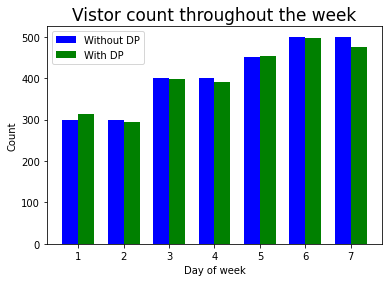

In [ ]:
ax = plt.subplot(111)
X = np.arange(len(np_count_day.keys()))
width = 0.35  # the width of the bars

ax.bar(X-width/2, np_count_day.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_count_day.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Count')
ax.set_xlabel('Day of week')
plt.xticks(X, np_count_day.keys())
plt.title("Vistor count throughout the week", fontsize=17)
plt.show()

### 各自で行うこと
* 最大のcontributionを変えて試す
 * 最大のContributuonを増やすと： 事前処理でデータが消えないが、ノイズが大きい
 * 最大のContributuonを減らすと： ノイズを抑えられるが、事前処理でデータが消える
* eplisonを変えて試す

## 集計2: 曜日毎の売上高 （事前集計によるSensitivityの低下）

続いて、ある週における、曜日毎の売上数を計測します。
ここでは、集計によっては、事前集計することでsensitivityを減らすことができることを学びます。

先ほどはcountでしたが、今度は曜日毎の売上集計を行うので、sumです。
countのsensitityは1ですが、sumの場合のsensitivityはPart１で説明したとおり、Uper bound - Lower boundで決まります。

簡単に考えると、それで良いのですが、sumのような処理の場合は事前集計ができる場合もあるので、コード例を見て学びましょう。

## 集計2-1:事前集計しない例

まずは、事前集計しない例を示します。

先ほどのcountの時と同様に、１日あたり最大4回購入する前提なので、最大のcontributionを4とします。

sumのsensitivityのためには、ECサイトで1人1回あたりの最大の購入金額（売上）の下限と上限を決める必要があります。ここでは、Lowerが0、Upperが50が妥当そうです。

なお、上記の条件でsensitivityを考えると、contributionが1〜4なので、Lowerが0x1=0、Upperが4x50=200なので、sensitivityは200となります。

コードの概要：
1. 関数定義: DPなしでのsum集計する関数
2. 関数定義: DPありでのsum集計する関数
3. 関数定義: DPあり・なしの関数を呼び出す関数
4. DPあり、DPなしの関数を呼び出して、結果表示

### 関数定義： DPノイズを入れずに、週毎にSumする関数

先ほどはcountでしたが、今度はsumです。

In [ ]:
def get_non_private_sum_revenue() -> dict:
        """Compute the revenue per day of visits without any differential privacy.

        Return a dictionary mapping days to revenue
        """
        day_revenue = dict()

        for day in _day_visits["Day"].unique():
            day_revenue[day] = _day_visits[_day_visits["Day"] == day][
                "Money spent (euros)"
            ].sum()

        return day_revenue

### 関数定義： DPノイズを入れて、週毎にSumする関数

先ほどはcountでしたが、今度はsumです。

In [ ]:
SUM_MAX_CONTRIBUTED_DAYS = 4 # Contributionの最大値
MIN_EUROS_SPENT = 0 # Lower bound
MAX_EUROS_SPENT_1 = 50 # Upper bound

def get_private_sum_revenue(epsilon: float = _epsilon) -> dict:
        day_visits = bound_visits_per_week(_day_visits, SUM_MAX_CONTRIBUTED_DAYS)

        day_revenue = dict()

        # Upper bound、Lower bound、contributionを設定
        x = BoundedSum(
            epsilon=epsilon,
            delta=0.0,
            lower_bound=MIN_EUROS_SPENT,
            upper_bound=MAX_EUROS_SPENT_1,
            l0_sensitivity=SUM_MAX_CONTRIBUTED_DAYS,
        )

        for day in day_visits["Day"].unique():
            x.reset()
            x.add_entries(
                data=list(day_visits[day_visits["Day"] == day]["Money spent (euros)"])
            )
            day_revenue[day] = int(x.result())

        return day_revenue


### 関数定義： DPノイズあり・なしのそれぞれの関数を呼ぶ関数

In [ ]:
def sum_revenue_per_day() -> tuple:
        non_private_sum = get_non_private_sum_revenue()
        private_sum = get_private_sum_revenue()

        return non_private_sum, private_sum

### 計算を実行

In [ ]:
np_sum_day, p_sum_day = sum_revenue_per_day()
np_sum_day = OrderedDict(sorted(np_sum_day.items()))
p_sum_day = OrderedDict(sorted(p_sum_day.items()))
print("Revenue per day:")
print("Without differential privacy:", np_sum_day)
print("With differential privacy:", p_sum_day)

Revenue per day:
Without differential privacy: OrderedDict([(1, 8678), (2, 8696), (3, 12088), (4, 12079), (5, 13765), (6, 16576), (7, 16500)])
With differential privacy: OrderedDict([(1, 8894), (2, 8177), (3, 13180), (4, 12050), (5, 13395), (6, 16152), (7, 17207)])


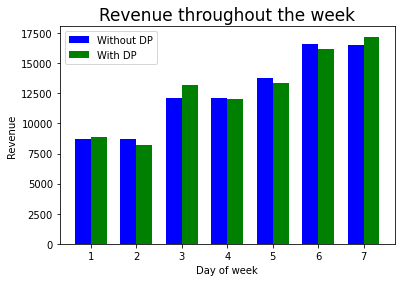

In [ ]:
ax = plt.subplot(111)
X = np.arange(len(np_sum_day.keys()))
width = 0.35  # the width of the bars
ax.bar(X-width/2, np_sum_day.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_sum_day.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Revenue')
ax.set_xlabel('Day of week')
plt.xticks(X, np_sum_day.keys())
plt.title("Revenue throughout the week", fontsize=17)
plt.show()

## 集計2-2:事前集計する例 (Sensitivityを減らせる）

ここで、sensitivityを減らせる可能性がある事に気づきます。

実際のデータを見ると、ECサイトで１日に4回購入する人は、各回の購入額が少ないことに気づきます。つまり、Upperが4x50=200というのは現実的ではないということです。1日の最大合計は65ユーロであることがわかりました。

sensitivity計算のためのLowerとUpperを、ある人が１日に購入する合計額のLowerとUpperとすると、週毎の集計のUpperとLowerを減らせることができます。
そのためには事前集計をして、DPノイズを入れる前のレコードは1名のその日の合計額を出し、それに対してUpper,Lower,contributionを設定すれば良いことになります。

新たなプライバシーパラメータ：
* 1日の1名の合計購入額のLowerは 0 (先ほどと変わらず)
* 1日の1名の合計購入額のUpperは 65
* 1日の1名の合計購入額なので、１名しか入っていないので、Contributionは1

### 関数定義：事前集計をして、sumを計算しDPノイズを入れる関数

In [ ]:
MAX_EUROS_SPENT_2 = 65 # 変更したUpper bound

def get_private_sum_revenue_with_preaggregation(
        epsilon: float = _epsilon
    ) -> dict:
        day_visits = bound_visits_per_week(_day_visits, SUM_MAX_CONTRIBUTED_DAYS)

        day_revenue = dict()

        #
        x = BoundedSum(
            epsilon=epsilon,
            delta=0.0,
            lower_bound=MIN_EUROS_SPENT, # lower bound
            upper_bound=MAX_EUROS_SPENT_2, # upper bound
            l0_sensitivity=1, # maxのcontributionは1にできる
        )

        for day in day_visits["Day"].unique():
            # For each visitor, 曜日毎に事前の集計処理を行う
            visits_on_day = day_visits[day_visits["Day"] == day][
                ["VisitorId", "Money spent (euros)"]
            ]
            visitor_to_spending = dict()

            # その後、DPノイズを付加する
            for visitor in visits_on_day["VisitorId"].unique():
                visitor_to_spending[visitor] = visits_on_day[
                    visits_on_day["VisitorId"] == visitor
                ]["Money spent (euros)"].sum()

            spending = list(visitor_to_spending.values())

            x.reset()
            x.add_entries(data=spending)
            day_revenue[day] = int(x.result())

        return day_revenue

### 関数定義： DPノイズあり・なしのそれぞれの関数を呼ぶ関数

In [ ]:
def sum_revenue_per_day_with_preaggregation() -> tuple:
        non_private_sum = get_non_private_sum_revenue()
        private_sum = get_private_sum_revenue_with_preaggregation()

        return non_private_sum, private_sum

### 計算を実行

In [ ]:
np_sum_day_pa, p_sum_day_pa = sum_revenue_per_day_with_preaggregation()
np_sum_day_pa = OrderedDict(sorted(np_sum_day_pa.items()))
p_sum_day_pa = OrderedDict(sorted(p_sum_day_pa.items()))
print("Revenue per day with preaggregation:")
print("Without differential privacy:", np_sum_day_pa)
print("With differential privacy:", p_sum_day_pa)

Revenue per day with preaggregation:
Without differential privacy: OrderedDict([(1, 8678), (2, 8696), (3, 12088), (4, 12079), (5, 13765), (6, 16576), (7, 16500)])
With differential privacy: OrderedDict([(1, 8488), (2, 8728), (3, 11923), (4, 12232), (5, 13863), (6, 16235), (7, 16062)])


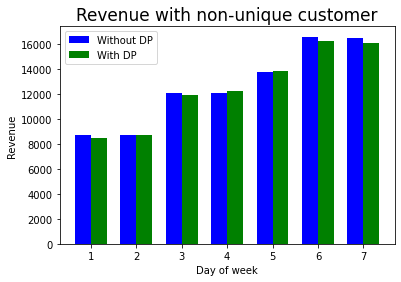

In [ ]:
ax = plt.subplot(111)
X = np.arange(len(np_sum_day_pa.keys()))
width = 0.35  # the width of the bars

ax.bar(X-width/2, np_sum_day_pa.values(), width=width, color='b', align='center')
ax.bar(X+width/2, p_sum_day_pa.values(), width=width, color='g', align='center')
ax.legend(('Without DP','With DP'))
ax.set_ylabel('Revenue')
ax.set_xlabel('Day of week')
plt.xticks(X, np_sum_day_pa.keys())
plt.title("Revenue with non-unique customer", fontsize=17)
plt.show()

先ほどよりもノイズが少ないように見えます

# まとめ

DPの応用として以下を学びました。
* 複数contributionへの対応方法、contributionの上限を設定
* 集計に応じたsensitibityの設計、事前集計によりsensitivityを減らす方法